In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
!pip install sklearn-genetic
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import time

from sklearn import datasets, linear_model
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

     |████████████████████████████████| 160 kB 5.2 MB/s 


## 1. Import Data

In [ ]:
# Upload the data file
from google.colab import files
uploaded = files.upload()

Saving patientfinal_2.csv to patientfinal_2.csv


In [ ]:
patient_df = pd.read_csv('patientfinal_2.csv')
patient_df.head(n=5)

,stay_id,icu_intime,aki_charttime,adm_age,weight,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,...,charlson_comorbidity_index,ace,arb,diuretic,immunosuppressant,increase_bp,infection,nsaid,opioid,reduce_bp
0,30001535,11/17/2177 20:30,11/17/2177 23:51,69,80.0,3,0,0,0,1,...,6,0,0,0,0,1,1,0,0,0
1,30002052,12/30/2180 5:24,12/31/2180 10:00,63,56.7,3,0,0,0,0,...,9,0,0,0,1,0,1,0,0,1
2,30002095,7/30/2190 14:35,NaN,63,106.9,3,1,1,1,0,...,7,1,0,1,0,0,0,0,0,1
3,30002198,1/4/2145 22:15,NaN,64,62.7,3,0,0,0,0,...,5,0,0,0,0,1,0,0,1,0
4,30002528,8/1/2177 22:56,NaN,49,118.0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [ ]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19375 entries, 0 to 19374
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   stay_id                      19375 non-null  int64  
 1   icu_intime                   19375 non-null  object 
 2   aki_charttime                10106 non-null  object 
 3   adm_age                      19375 non-null  int64  
 4   weight                       19253 non-null  float64
 5   age_score                    19375 non-null  int64  
 6   myocardial_infarct           19375 non-null  int64  
 7   congestive_heart_failure     19375 non-null  int64  
 8   peripheral_vascular_disease  19375 non-null  int64  
 9   cerebrovascular_disease      19375 non-null  int64  
 10  dementia                     19375 non-null  int64  
 11  chronic_pulmonary_disease    19375 non-null  int64  
 12  rheumatic_disease            19375 non-null  int64  
 13  peptic_ulcer_dis

## 2. Fix the dtype

In [ ]:
patient_df['stay_id'] = patient_df['stay_id'].astype('object') # patient id: from int to string
patient_df.iloc[:, 5:] = patient_df.iloc[:, 5:].apply(lambda x: x.astype('category')) # from int to category

In [ ]:
# change to 'datatime' formart
patient_df['icu_intime'] = pd.to_datetime(patient_df['icu_intime'])
patient_df['aki_charttime'] = pd.to_datetime(patient_df['aki_charttime'])

In [ ]:
# check the timestamps
patient_df[['icu_intime', 'aki_charttime']].head(n=5)

,icu_intime,aki_charttime
0,2177-11-17 20:30:00,2177-11-17 23:51:00
1,2180-12-30 05:24:00,2180-12-31 10:00:00
2,2190-07-30 14:35:00,NaT
3,2145-01-04 22:15:00,NaT
4,2177-08-01 22:56:00,NaT


In [ ]:
# AKI onset time gap (round to hour)
patient_df['time_delta'] = (patient_df['aki_charttime'] - patient_df['icu_intime']).astype('timedelta64[ns]').round('h')

In [ ]:
# AKI binary label: yes or no
patient_df['AKI'] = np.where(patient_df['time_delta'].isnull(), 0, 1)
patient_df['AKI'] = patient_df['AKI'].astype('category')
patient_df['AKI'].value_counts()

1    10106
0     9269
Name: AKI, dtype: int64

In [ ]:
# check the feature properties
## 1. continuous variables
patient_df.describe(include = ['float64','timedelta64[ns]'])

,weight,time_delta
count,19253.000000,10106
mean,81.295055,0 days 16:07:24.567583613
std,25.591159,0 days 10:24:36.243541228
min,1.000000,0 days 00:00:00
25%,65.500000,0 days 08:00:00
50%,78.200000,0 days 13:00:00
75%,93.100000,0 days 22:00:00
max,850.000000,2 days 00:00:00


In [ ]:
## 2. categorical variables
patient_df.describe(include = ['category'])

,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,...,ace,arb,diuretic,immunosuppressant,increase_bp,infection,nsaid,opioid,reduce_bp,AKI
count,19375,19375,19375,19375,19375,19375,19375,19375,19375,19375,...,19375,19375,19375,19375,19375,19375,19375,19375,19375,19375
unique,5,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
freq,8504,15790,13991,17183,16094,18289,14670,18672,18873,17560,...,18064,18794,14880,16501,11924,11194,12654,11093,10872,10106


## 3. Outliers and missing values

In [ ]:
patient_df['weight'] = patient_df['weight'].mask(patient_df['weight'] > 250, np.nan)

check NAs

In [ ]:
patient_df.isnull().sum()

stay_id                           0
icu_intime                        0
aki_charttime                  9269
adm_age                           0
weight                          130
age_score                         0
myocardial_infarct                0
congestive_heart_failure          0
peripheral_vascular_disease       0
cerebrovascular_disease           0
dementia                          0
chronic_pulmonary_disease         0
rheumatic_disease                 0
peptic_ulcer_disease              0
mild_liver_disease                0
diabetes_without_cc               0
diabetes_with_cc                  0
paraplegia                        0
renal_disease                     0
malignant_cancer                  0
severe_liver_disease              0
metastatic_solid_tumor            0
aids                              0
charlson_comorbidity_index        0
ace                               0
arb                               0
diuretic                          0
immunosuppressant           

### kNN imputation for missing values

In [ ]:
scaler = MinMaxScaler()
patient_df[['adm_age', 'weight']] = scaler.fit_transform(patient_df[['adm_age', 'weight']])

In [ ]:
feature_name = patient_df.iloc[:, 3:-2].keys()
print(feature_name)

Index(['adm_age', 'weight', 'age_score', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'charlson_comorbidity_index', 'ace',
       'arb', 'diuretic', 'immunosuppressant', 'increase_bp', 'infection',
       'nsaid', 'opioid', 'reduce_bp'],
      dtype='object')


In [ ]:
X = patient_df.iloc[:, 3:-2]
y = patient_df['AKI']

In [ ]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit on the dataset
imputer.fit(X)

KNNImputer()

In [ ]:
# transform the dataset
X = imputer.transform(X)

In [ ]:
# double check if there is missing values left
print('Missing: %d' % sum(np.isnan(X).flatten()))

Missing: 0


## 4. Baseline without feature selection

### Data split

In [ ]:
print(X.shape)
print(y.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

(19375, 30)
(19375,)


In [ ]:
print(np.shape(X_train))
print(np.shape(X_test))

(15500, 30)
(3875, 30)


In [ ]:
# function to print result
def print_result(acc_train, acc_test, auroc):
  txt1 = "Train Accuracy: {:.2f} %".format(acc_train*100)
  txt2 = "Test Accuracy : {:.2f} %".format(acc_test*100)
  txt3 = "AUROC         : {:.2f}\n".format(auroc)
  print(txt1)
  print(txt2)
  print(txt3)

In [ ]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score 
print("---------- Logistic Regression ----------")

# ----------- without regularization -----------  #
print("Without regularization")

clf = LogisticRegression(penalty='none',solver='newton-cg').fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

print("--------------------------------------")

# ----------- with regularization -----------  #
# with various C values (smaller C, higher regularization)
c_list = [0.001, 0.1, 1]

# with L1 regularization (Lasso Regression)
print("With L1/Lasso Regularization")
for c in c_list:
  clf = LogisticRegression(penalty='l1', solver='liblinear', C=c).fit(X_train, y_train)
  acc_train   = clf.score(X_train, y_train)
  acc_test    = clf.score(X_test , y_test )
  auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
  txt1 = "When C is {}".format(c)
  print(txt1)
  print_result(acc_train, acc_test, auroc)

print("--------------------------------------")
# with L2 regularization (Ridge Regression)
print("With L2/Ridge Regularization")
for c in c_list:
  clf = LogisticRegression(penalty='l2',solver='newton-cg', C=c).fit(X_train, y_train)
  acc_train   = clf.score(X_train, y_train)
  acc_test    = clf.score(X_test , y_test )
  auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
  txt1 = "When C is {}".format(c)
  print(txt1)
  print_result(acc_train, acc_test, auroc)


---------- Logistic Regression ----------
Without regularization
Train Accuracy: 69.10 %
Test Accuracy : 69.14 %
AUROC         : 0.76

--------------------------------------
With L1/Lasso Regularization
When C is 0.001
Train Accuracy: 54.04 %
Test Accuracy : 53.14 %
AUROC         : 0.61

When C is 0.1
Train Accuracy: 68.78 %
Test Accuracy : 69.03 %
AUROC         : 0.76

When C is 1
Train Accuracy: 68.97 %
Test Accuracy : 69.01 %
AUROC         : 0.76

--------------------------------------
With L2/Ridge Regularization
When C is 0.001
Train Accuracy: 65.95 %
Test Accuracy : 66.63 %
AUROC         : 0.73

When C is 0.1
Train Accuracy: 68.61 %
Test Accuracy : 69.34 %
AUROC         : 0.76

When C is 1
Train Accuracy: 68.89 %
Test Accuracy : 69.06 %
AUROC         : 0.76



In [ ]:
# Model 2: Decision Tree
from sklearn.tree import DecisionTreeClassifier
print("---------- Decision Tree ----------")
clf = DecisionTreeClassifier().fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)


---------- Decision Tree ----------
Train Accuracy: 99.97 %
Test Accuracy : 60.31 %
AUROC         : 0.60



In [ ]:
# Model 3: Random Forest
from sklearn.ensemble import RandomForestClassifier
print("---------- Random Forest ----------")
clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, max_features="auto").fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Random Forest ----------
Train Accuracy: 99.97 %
Test Accuracy : 60.65 %
AUROC         : 0.61



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='rbf', degree=3, probability=True).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 67.21 %
Test Accuracy : 67.46 %
AUROC         : 0.75



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=1, probability=True).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 66.50 %
Test Accuracy : 66.74 %
AUROC         : 0.75



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=2, probability=True).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 67.12 %
Test Accuracy : 67.28 %
AUROC         : 0.75



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=3, probability=True).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 66.56 %
Test Accuracy : 66.30 %
AUROC         : 0.74



In [ ]:
# Model 5: Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
print("---------- Gradient Boost ----------")
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Gradient Boost ----------
Train Accuracy: 68.06 %
Test Accuracy : 68.49 %
AUROC         : 0.75



In [ ]:
# Model 6: Ada-Boost
from sklearn.ensemble import AdaBoostClassifier
print("---------- Ada-Boost ----------")
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=0).fit(X_train, y_train)
acc_train   = clf.score(X_train, y_train)
acc_test    = clf.score(X_test , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Ada-Boost ----------
Train Accuracy: 68.15 %
Test Accuracy : 68.36 %
AUROC         : 0.75



epoch= 99 	 time= 4.17 min 	 loss= 0.009 	 error= 28.60%
error rate on test set = 30.45%
AUROC on test set = 0.72


<Figure size 432x288 with 0 Axes>

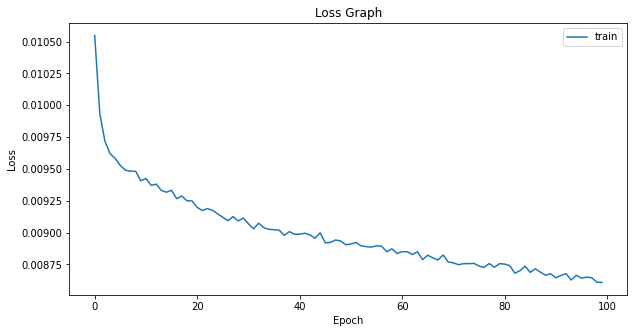

<Figure size 432x288 with 0 Axes>

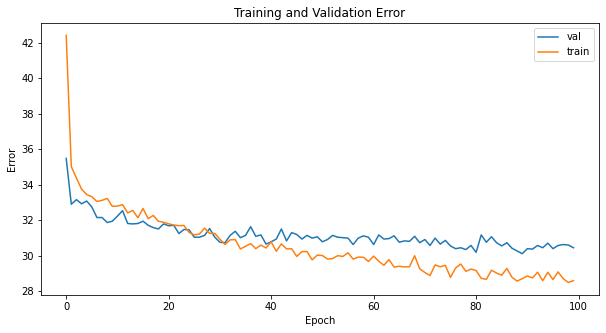

<Figure size 432x288 with 0 Axes>

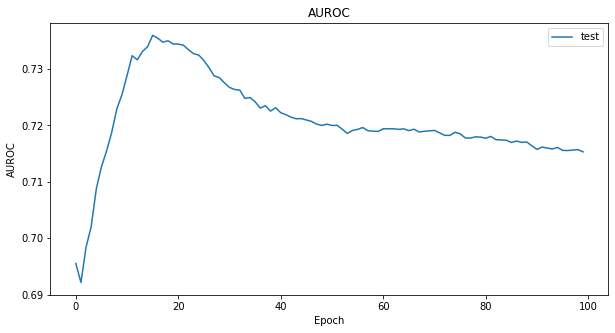

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model 7: Neural Network

# Try all the features
num_features = 30  # 30 original features

device = "cpu"
print("device: ", device)

class NeuralNet(torch.nn.Module):
    def __init__(self, num_features, hid_dim, out_dim):
        super(NeuralNet, self).__init__()
       
        import torch.nn as nn
        import torch.nn.functional as F
        
        self.num_features = num_features
        self.hid_dim      = hid_dim
        self.out_dim      = out_dim
        self.fc1   = nn.Linear(self.num_features, out_features= self.hid_dim )
        self.fc2   = nn.Linear(self.hid_dim , out_features= self.hid_dim ) # 128, 256
        self.fc3   = nn.Linear(self.hid_dim , out_features= self.out_dim )
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x.view(-1, 1).squeeze(1)

model = NeuralNet(num_features, 256, 1)
model.to(device)
print(model)

# Hyperparameters
epochs = 100
batch_size = 64
learning_rate = 1e-4 #0.01 #1e-4

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
# Define loss function
criterion = torch.nn.BCEWithLogitsLoss() # Binary cross entropy loss / + with logits 

# Data Loader
train_loader = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train.reset_index(drop=True)).type(torch.LongTensor))
test_loader  = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test.reset_index(drop=True)).type(torch.LongTensor))

train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=False, num_workers=1)

train_size = len(y_train.values)
test_size  = len(y_test.values)

def eval_on_test_set(model):
    model.eval()
    running_error = 0
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.preprocessing import StandardScaler
    z = StandardScaler().fit(X_train)

    for data in test_loader:
        inputs = data[0]
        labels = data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        prediction = torch.round(torch.sigmoid(outputs)) 
        
        error = (prediction != labels).sum().item()
        running_error += error

    # AUROC
    auroc = roc_auc_score(y_test, model(torch.Tensor(z.transform(X_test))).detach().flatten().numpy())

    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    print('AUROC on test set = {:.2f}'.format(auroc))
    model.train()
    
    return total_error, auroc

import time
from IPython import display
from sklearn.metrics import accuracy_score, roc_auc_score

def train_net(model):
    start=time.time()
    model.train()
    
    import matplotlib.pyplot as plt
    loss_train  = []
    error_val   = []
    error_train = []
    auroc_curve = []

    for epoch in range(epochs):
        running_loss = 0
        running_error = 0
    
        for data in train_loader:

            inputs = data[0]
            labels = data[1].float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            prediction = torch.round(torch.sigmoid(outputs))

            error = (prediction != labels).sum().item()
            running_error += error

        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        display.clear_output(wait=True)

        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        val_error, auroc_test = eval_on_test_set(model) 

        # Plot loss graph
        loss_train.append(total_loss)
        plt.figure(1)
        plt.figure(figsize=(10,5))
        plt.title("Loss Graph")
        plt.plot(loss_train,label="train")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        error_train.append(total_error*100)
        error_val.append(val_error*100)
        plt.figure(2)
        plt.figure(figsize=(10,5))
        plt.title("Training and Validation Error")
        plt.plot(error_val,label="val")
        plt.plot(error_train,label="train")
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend()
        plt.show()

        # Plot AUROC graph
        auroc_curve.append(auroc_test)
        plt.figure(3)
        plt.figure(figsize=(10,5))
        plt.title("AUROC")
        plt.plot(auroc_curve,label="test")
        plt.xlabel("Epoch")
        plt.ylabel("AUROC")
        plt.legend()
        plt.show()

# Start training
train_net(model)
# Save the trained model
torch.save(model.state_dict(), 'nn_checkpoint256_base.pth')
files.download('nn_checkpoint256_base.pth')


## 5. Feature selection

### Permutation scores

In [ ]:
start_time = time.time()

selector = RandomForestClassifier(random_state=42, n_jobs = 2, n_estimators=500, class_weight = 'balanced')
selector.fit(X_train, y_train)

perm_score = permutation_importance(selector, X_train, y_train, n_repeats=10, random_state=42, n_jobs=5)

print("---Feature selection finished in %s seconds ---" %  (time.time() - start_time))

---Feature selection finished in 534.9188327789307 seconds ---


In [ ]:
sorted_idx = perm_score.importances_mean.argsort() # from low to high
sorted_idx

array([19,  9, 10, 18, 22, 14,  7, 17, 13, 11, 16, 21,  5, 12,  6,  8, 15,
        3, 24,  2, 29, 23, 27, 26, 20,  4, 28,  0, 25,  1])

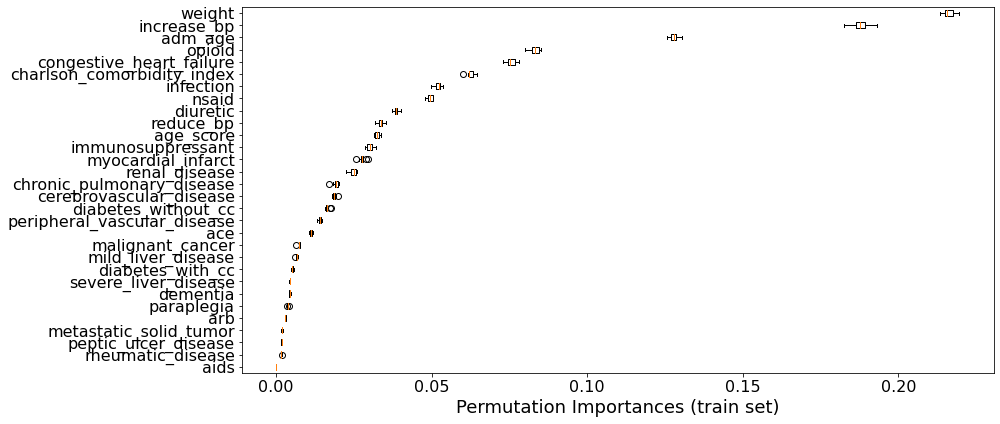

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.boxplot(perm_score.importances[sorted_idx].T, vert=False, labels=feature_name[sorted_idx])
plt.xlabel('Permutation Importances (train set)', fontsize=18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
fig.tight_layout()
plt.show()

In [ ]:
# Measuring the performance on validation set with models trained with different number of top k features.

parsi = {}
scoring = {'acc': 'accuracy',
           'auc': 'roc_auc'}

sorted_idx = sorted_idx[::-1]

val_auc = []
val_acc = []

for k in range(len(sorted_idx)):
    subset = X_train[:, sorted_idx[:k+1]]
    selector.fit(subset, y_train)
    
    y_test_pred = selector.predict(X_test[:, sorted_idx[:k+1]])
    y_test_score = selector.predict_proba(X_test[:, sorted_idx[:k+1]])

    #cv_results.append(cv_result)
    runtime = (time.time() - start_time)
    
    val_acc.append(accuracy_score(y_test, y_test_pred))
    val_auc.append(roc_auc_score(y_test, y_test_score[:, 1]))
    

    print("Top",k+1,"is Done")

Top 1 is Done
Top 2 is Done
Top 3 is Done
Top 4 is Done
Top 5 is Done
Top 6 is Done
Top 7 is Done
Top 8 is Done
Top 9 is Done
Top 10 is Done
Top 11 is Done
Top 12 is Done
Top 13 is Done
Top 14 is Done
Top 15 is Done
Top 16 is Done
Top 17 is Done
Top 18 is Done
Top 19 is Done
Top 20 is Done
Top 21 is Done
Top 22 is Done
Top 23 is Done
Top 24 is Done
Top 25 is Done
Top 26 is Done
Top 27 is Done
Top 28 is Done
Top 29 is Done
Top 30 is Done


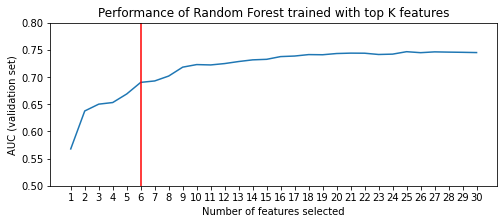

In [ ]:
plt.figure(figsize=[8, 3])
plt.xlabel("Number of features selected")
plt.ylabel("AUC (validation set)")
plt.title("Performance of Random Forest trained with top K features")
plt.plot(range(1,len(feature_name)+1), val_auc)
plt.ylim([0.5, 0.8])
plt.axvline(x=6, c = 'r')
plt.xticks(range(1,len(feature_name)+1))
#plt.legend()
plt.show()

## Model Evaluation

In [ ]:
# Transform the dataset with top 11 features selected
X_train_selected = X_train[:, sorted_idx[:11]]
X_test_selected = X_test[:, sorted_idx[:11]]

In [ ]:
print(np.shape(X_train_selected))
print(np.shape(y_train))
print(np.shape(X_test_selected))
print(np.shape(y_test))

print(np.shape(X_train))

(15500, 11)
(15500,)
(3875, 11)
(3875,)
(15500, 30)


# Train model with selected data from **feature selection**

In [ ]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score 
print("---------- Logistic Regression ----------")

# ----------- without regularization -----------  #
print("Without regularization")

clf = LogisticRegression(penalty='none',solver='newton-cg').fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

print("--------------------------------------")

# ----------- with regularization -----------  #
# with various C values (smaller C, higher regularization)
c_list = [0.001, 0.1, 1]

# with L1 regularization (Lasso Regression)
print("With L1/Lasso Regularization")
for c in c_list:
  clf = LogisticRegression(penalty='l1', solver='liblinear', C=c).fit(X_train_selected, y_train)
  acc_train   = clf.score(X_train_selected, y_train)
  acc_test    = clf.score(X_test_selected , y_test )
  auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
  txt1 = "When C is {}".format(c)
  print(txt1)
  print_result(acc_train, acc_test, auroc)

print("--------------------------------------")
# with L2 regularization (Ridge Regression)
print("With L2/Ridge Regularization")
for c in c_list:
  clf = LogisticRegression(penalty='l2',solver='newton-cg', C=c).fit(X_train_selected, y_train)
  acc_train   = clf.score(X_train_selected, y_train)
  acc_test    = clf.score(X_test_selected , y_test )
  auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
  txt1 = "When C is {}".format(c)
  print(txt1)
  print_result(acc_train, acc_test, auroc)


---------- Logistic Regression ----------
Without regularization
Train Accuracy: 68.14 %
Test Accuracy : 68.23 %
AUROC         : 0.75

--------------------------------------
With L1/Lasso Regularization
When C is 0.001
Train Accuracy: 54.04 %
Test Accuracy : 53.14 %
AUROC         : 0.61

When C is 0.1
Train Accuracy: 67.99 %
Test Accuracy : 68.65 %
AUROC         : 0.75

When C is 1
Train Accuracy: 68.14 %
Test Accuracy : 68.34 %
AUROC         : 0.75

--------------------------------------
With L2/Ridge Regularization
When C is 0.001
Train Accuracy: 64.96 %
Test Accuracy : 65.52 %
AUROC         : 0.71

When C is 0.1
Train Accuracy: 67.83 %
Test Accuracy : 68.18 %
AUROC         : 0.75

When C is 1
Train Accuracy: 68.14 %
Test Accuracy : 68.36 %
AUROC         : 0.75



In [ ]:
# Model 2: Decision Tree
from sklearn.tree import DecisionTreeClassifier
print("---------- Decision Tree ----------")
clf = DecisionTreeClassifier().fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)


---------- Decision Tree ----------
Train Accuracy: 99.93 %
Test Accuracy : 59.15 %
AUROC         : 0.59



In [ ]:
# Model 3: Random Forest
from sklearn.ensemble import RandomForestClassifier
print("---------- Random Forest ----------")
clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, max_features="auto").fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Random Forest ----------
Train Accuracy: 99.93 %
Test Accuracy : 60.88 %
AUROC         : 0.61



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='rbf', degree=3, probability=True).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 66.01 %
Test Accuracy : 66.63 %
AUROC         : 0.74



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=1, probability=True).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 63.95 %
Test Accuracy : 64.70 %
AUROC         : 0.74



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=2, probability=True).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 66.18 %
Test Accuracy : 67.20 %
AUROC         : 0.74



In [ ]:
# Model 4: SVM
from sklearn import svm
print("---------- Support Vector Machine ----------")
clf = svm.SVC(C=1, kernel='poly', degree=3, probability=True).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Support Vector Machine ----------
Train Accuracy: 65.35 %
Test Accuracy : 66.45 %
AUROC         : 0.73



In [ ]:
# Model 5: Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
print("---------- Gradient Boost ----------")
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Gradient Boost ----------
Train Accuracy: 67.94 %
Test Accuracy : 68.18 %
AUROC         : 0.75



In [ ]:
# Model 6: Ada-Boost
from sklearn.ensemble import AdaBoostClassifier
print("---------- Ada-Boost ----------")
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=0).fit(X_train_selected, y_train)
acc_train   = clf.score(X_train_selected, y_train)
acc_test    = clf.score(X_test_selected , y_test )
auroc       = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])
print_result(acc_train, acc_test, auroc)

---------- Ada-Boost ----------
Train Accuracy: 67.94 %
Test Accuracy : 68.10 %
AUROC         : 0.75



epoch= 99 	 time= 4.15 min 	 loss= 0.009 	 error= 31.76%
error rate on test set = 31.48%
AUROC on test set = 0.71


<Figure size 432x288 with 0 Axes>

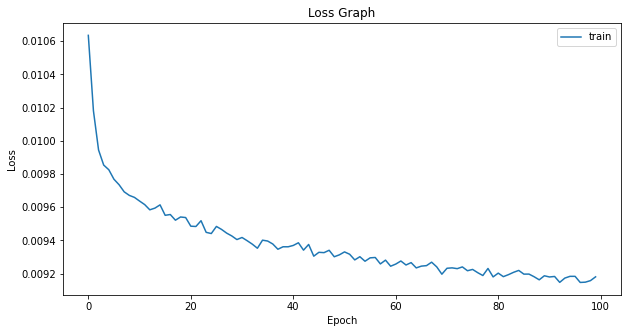

<Figure size 432x288 with 0 Axes>

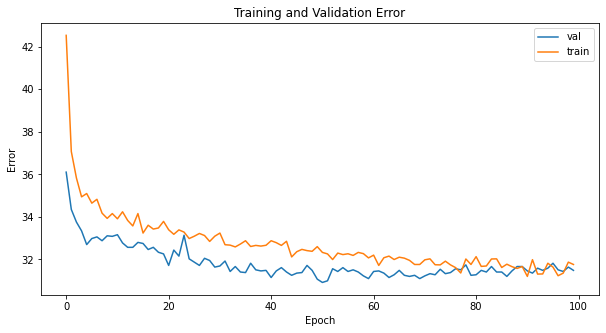

<Figure size 432x288 with 0 Axes>

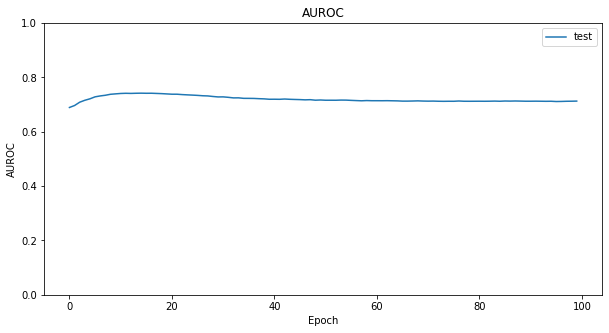

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model 7: Neural Network

# only selected features
num_features = 11  # 11 features

device = "cpu"
print("device: ", device)

class NeuralNet(torch.nn.Module):
    def __init__(self, num_features, hid_dim, out_dim):
        super(NeuralNet, self).__init__()
       
        import torch.nn as nn
        import torch.nn.functional as F
        
        self.num_features = num_features
        self.hid_dim      = hid_dim
        self.out_dim      = out_dim
        self.fc1   = nn.Linear(self.num_features, out_features= self.hid_dim )
        self.fc2   = nn.Linear(self.hid_dim , out_features= self.hid_dim ) # 128, 256
        self.fc3   = nn.Linear(self.hid_dim , out_features= self.out_dim )
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x.view(-1, 1).squeeze(1)

model = NeuralNet(num_features, 256, 1)
model.to(device)
print(model)

# Hyperparameters
epochs = 100
batch_size = 64
learning_rate = 1e-4 #0.01 #1e-4

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer
# Define loss function
criterion = torch.nn.BCEWithLogitsLoss() # Binary cross entropy loss / + with logits 

# Data Loader
train_loader = torch.utils.data.TensorDataset(torch.Tensor(X_train_selected), torch.Tensor(y_train.reset_index(drop=True)).type(torch.LongTensor))
test_loader  = torch.utils.data.TensorDataset(torch.Tensor(X_test_selected), torch.Tensor(y_test.reset_index(drop=True)).type(torch.LongTensor))

train_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=False, num_workers=1)

train_size = len(y_train.values)
test_size  = len(y_test.values)

def eval_on_test_set(model):
    model.eval()
    running_error = 0
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.preprocessing import StandardScaler
    z = StandardScaler().fit(X_train_selected)

    for data in test_loader:
        inputs = data[0]
        labels = data[1]
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        prediction = torch.round(torch.sigmoid(outputs)) 
        
        error = (prediction != labels).sum().item()
        running_error += error

    # AUROC
    auroc = roc_auc_score(y_test, model(torch.Tensor(z.transform(X_test_selected))).detach().flatten().numpy())

    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    print('AUROC on test set = {:.2f}'.format(auroc))
    model.train()
    
    return total_error, auroc

import time
from IPython import display
from sklearn.metrics import accuracy_score, roc_auc_score

def train_net(model):
    start=time.time()
    model.train()
    
    import matplotlib.pyplot as plt
    loss_train  = []
    error_val   = []
    error_train = []
    auroc_curve = []

    for epoch in range(epochs):
        running_loss = 0
        running_error = 0
    
        for data in train_loader:

            inputs = data[0]
            labels = data[1].float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            prediction = torch.round(torch.sigmoid(outputs))

            error = (prediction != labels).sum().item()
            running_error += error

        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60

        display.clear_output(wait=True)

        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        val_error, auroc_test = eval_on_test_set(model) 

        # Plot loss graph
        loss_train.append(total_loss)
        plt.figure(1)
        plt.figure(figsize=(10,5))
        plt.title("Loss Graph")
        plt.plot(loss_train,label="train")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        error_train.append(total_error*100)
        error_val.append(val_error*100)
        plt.figure(2)
        plt.figure(figsize=(10,5))
        plt.title("Training and Validation Error")
        plt.plot(error_val,label="val")
        plt.plot(error_train,label="train")
        plt.xlabel("Epoch")
        plt.ylabel("Error")
        plt.legend()
        plt.show()

        # Plot AUROC graph
        auroc_curve.append(auroc_test)
        plt.figure(3)
        plt.figure(figsize=(10,5))
        plt.title("AUROC")
        plt.plot(auroc_curve,label="test")
        plt.xlabel("Epoch")
        plt.ylabel("AUROC")
        plt.legend()
        plt.ylim([0, 1])
        plt.show()

    return auroc_curve

# Start training
auroc_curve_11_features_256 = train_net(model)
# Save the trained model
torch.save(model.state_dict(), 'nn_checkpoint256_feature_selection.pth')
files.download('nn_checkpoint256_feature_selection.pth')
